targets.shape=(36, 2)


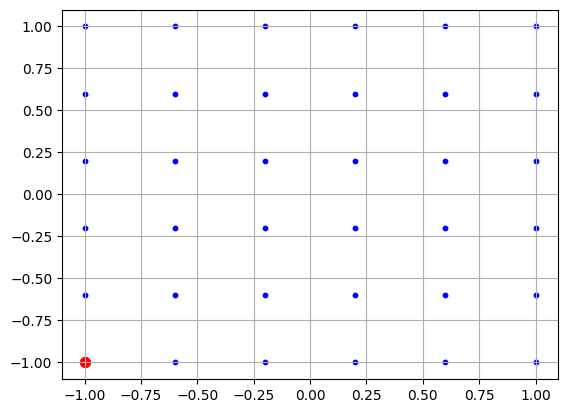

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = int(6)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(6)
# Choose the redundancy parameter (have each target be visited by exactly that many robots)
rp = min(3, k)

# Fuel Capacity Parameters
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 4.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
depots = np.concatenate((depots, depots))
depot_indices = range(len(targets), len(targets)+len(depots))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = range(len(targets)+len(depots))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(38, 38)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
# Note: All edges are now binary
x = m.addMVar((k,len(node_indices),len(node_indices)), name='x', vtype=GRB.BINARY)
# for ki in range(k):
#     for i in target_indices:
#         for j in target_indices:
#             if i == j: continue
#             _ = m.addConstr(x[ki,i,j] <= 1)
#         for j in depot_indices:
#             _ = m.addConstr(x[ki,i,j] <= 1)
#             _ = m.addConstr(x[ki,j,i] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2419685
Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i,:].sum() == rp for i in target_indices)
_ = m.addConstrs(x[:,:,i].sum() == rp for i in target_indices)

for ki in range(k):
    if rp > 1:
        _ = m.addConstrs(x[ki,i,:].sum() <= 1 for i in target_indices)
        _ = m.addConstrs(x[ki,:,i].sum() <= 1 for i in target_indices)

    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki,B_k[ki],:].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki,:,B_k[ki]].sum() <= 1)
    
    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,i]-x[ki,i,:]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)

In [5]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,len(node_indices),len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki,i,j]
    _ = m.addConstr((p[ki,B_k[ki],:] - p[ki,:,B_k[ki]]).sum() == right_side)
    
    for i in target_indices:
        _ = m.addConstr((p[ki,:,i] - p[ki,i,:]).sum() == x[ki,i,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki,j,i] - p[ki,i,j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i,j] <= len(target_indices) * x[ki,i,j] for i in node_indices for j in node_indices)

In [6]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
r = m.addMVar((k,len(node_indices),len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[ki,j,i] - r[ki,i,j] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[ki,j,i] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[ki,j,i] - cost[j,i] >= -M * (1 - x[ki,j,i]))

In [7]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

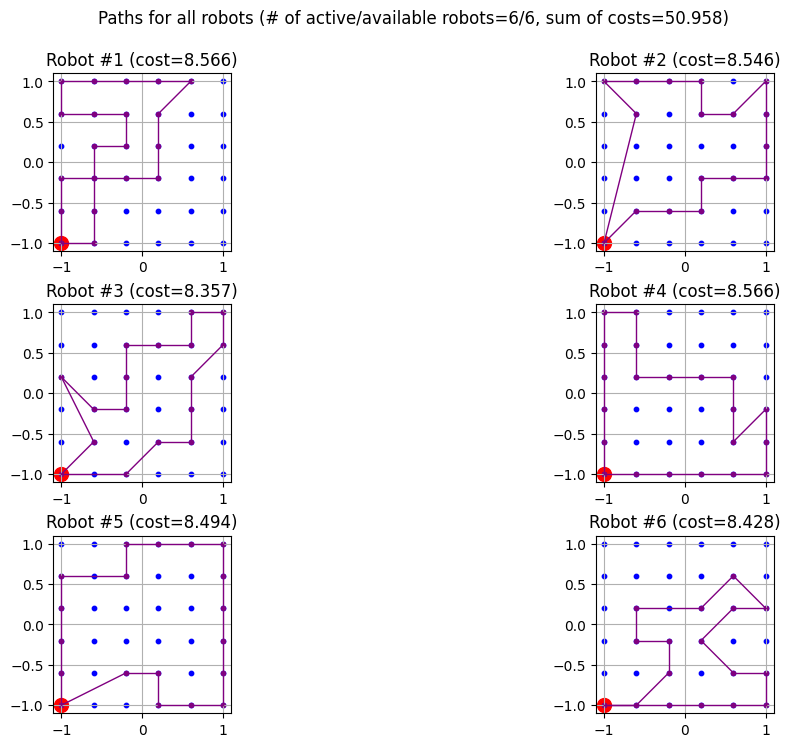

In [26]:
import datetime


def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki,i,j] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)
        
        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()
    
    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)
    
    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    fig.savefig(f"../../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png") 
    plt.show()

visualize_paths_brute_force(MILPSolver.min_cost_edges)

In [31]:
def get_next_nodes(edges, node):
    next_nodes = []
    for n_i in node_indices:
        if edges[node,n_i]:
            next_nodes.append(n_i)
    return next_nodes

def visualize_paths_faster(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        search_ongoing = True
        found = set()
        visited = set()
        # path_lookup = {}
        curr_node = depot_indices[0]
        while search_ongoing:
            if curr_node in depot_indices:
                print(f" -> D{curr_node}/({nodes[curr_node, 0]:.2f},{nodes[curr_node, 1]:.2f})")
            else:
                print(f" -> T{curr_node}/({nodes[curr_node, 0]:.2f},{nodes[curr_node, 1]:.2f})")

            visited.add(curr_node)
            neighbor_nodes = get_next_nodes(edges[ki], curr_node)
            print(f"\t{neighbor_nodes=}")

            for neighbor_node in neighbor_nodes:
                if neighbor_node not in found:
                    found.add(neighbor_node)

            found_next_node = False
            for neighbor_node in neighbor_nodes:
                if neighbor_node not in visited:
                    ax.scatter(nodes[curr_node, 0], nodes[curr_node, 1], c="purple", s=8)
                    ax.plot([nodes[curr_node, 0], nodes[neighbor_node, 0]], [nodes[curr_node, 1], nodes[neighbor_node, 1]], color="purple", linewidth=1)
                    curr_node = neighbor_node
                    found_next_node = True
                    break

            if found_next_node:
                search_ongoing = True
            elif not found_next_node and len(found) != len(visited):
                search_ongoing = True
                # print(f"{(found - visited)=}")
                print("Visualizing another loop...")
                curr_node = (found - visited).pop()
            else:
                search_ongoing = False

            # print(f"{found_next_node=} , {len(found)=} {len(visited)=}")
        
        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()


    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)

    plt.grid()
    plt.show()


In [10]:

class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    def __init__(self, model):
        self.model = model
                
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            
            # If this solution's maximum costing tour ~= the cost of tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()
            
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com
Optimize a model with 26718 rows, 25993 columns and 157794 nonzeros
Model fingerprint: 0x62cdac30
Variable types: 8665 continuous, 17328 integer (8664 binary)
Coefficient statistics:
  Matrix range     [4e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 13524 rows and 8904 columns
Presolve time: 0.11s
Presolved: 13194 rows, 17089 columns, 99312 nonzeros
Variable types: 1 continuous, 17088 integer (8652 binary)
Found a new solution with lower cost(71.286)!


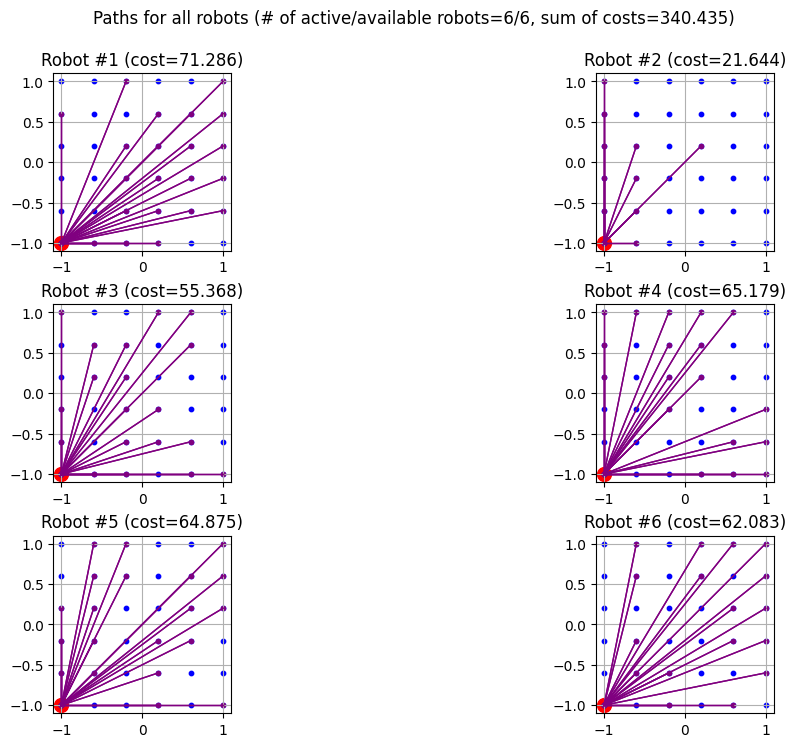

Found heuristic solution: objective 71.2856839
Found a new solution with lower cost(71.233)!


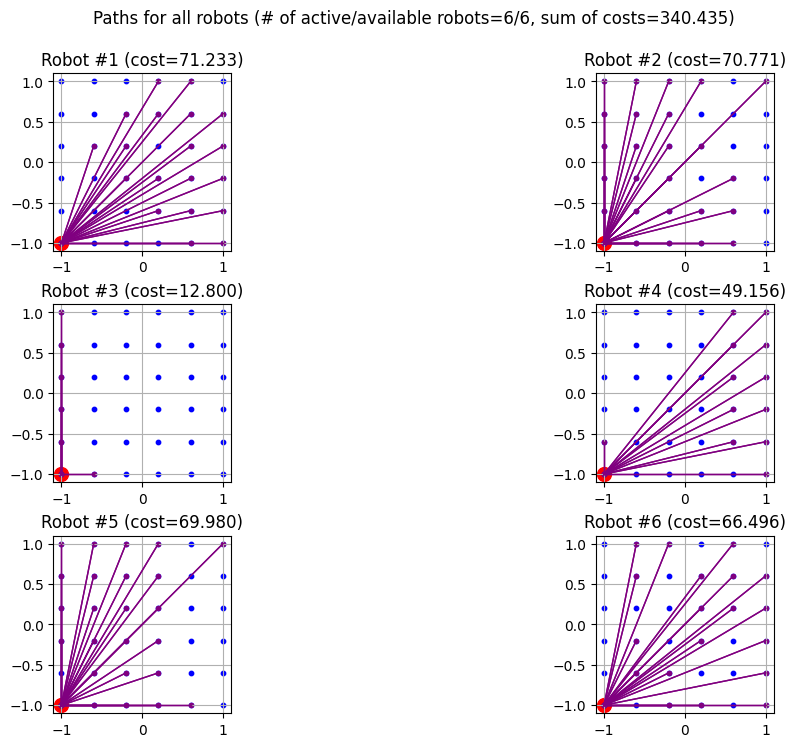

Found heuristic solution: objective 71.2325227

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   21247    7.1983461e+00   1.005766e+02   0.000000e+00      5s
   23152    7.1967456e+00   0.000000e+00   0.000000e+00      5s

Root relaxation: objective 7.196746e+00, 23152 iterations, 2.04 seconds (6.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.19675    0  540   71.23252    7.19675  89.9%     -    7s
Found a new solution with lower cost(69.980)!


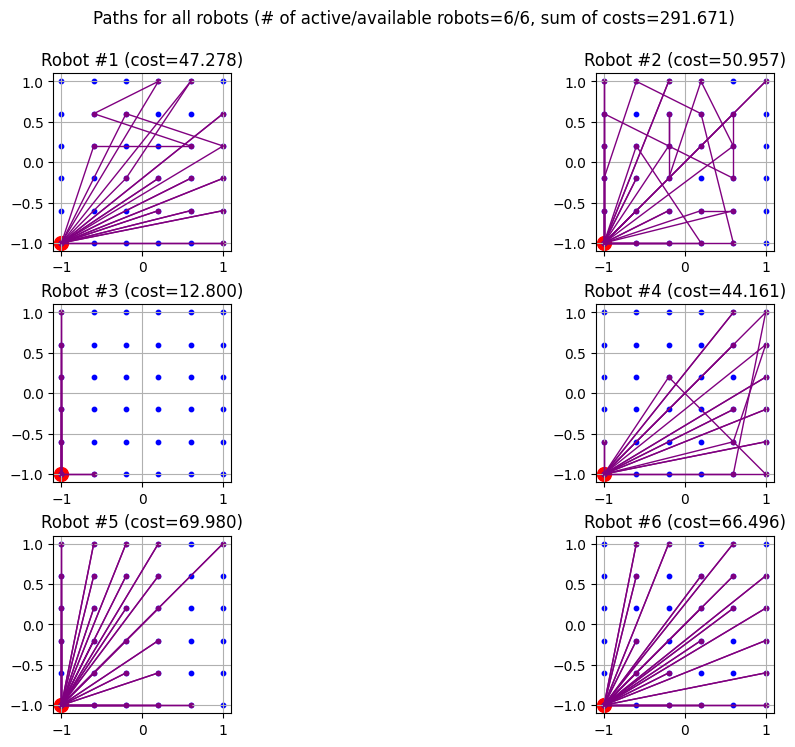

H    0     0                      69.9796166    7.19675  89.7%     -    9s
     0     0    7.19675    0  739   69.97962    7.19675  89.7%     -   10s
Found a new solution with lower cost(18.071)!


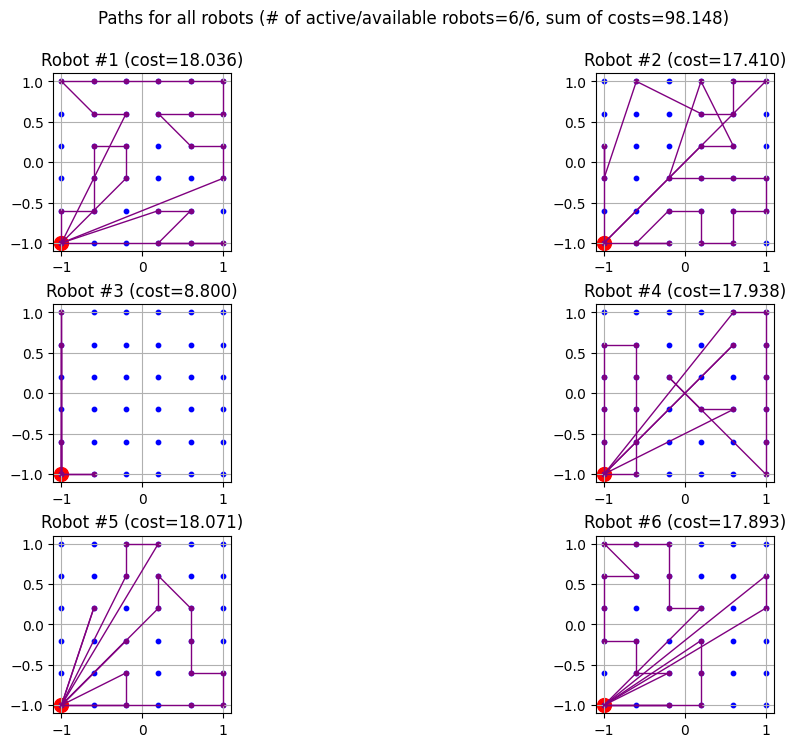

H    0     0                      18.0709679    7.19675  60.2%     -   14s
Found a new solution with lower cost(15.424)!


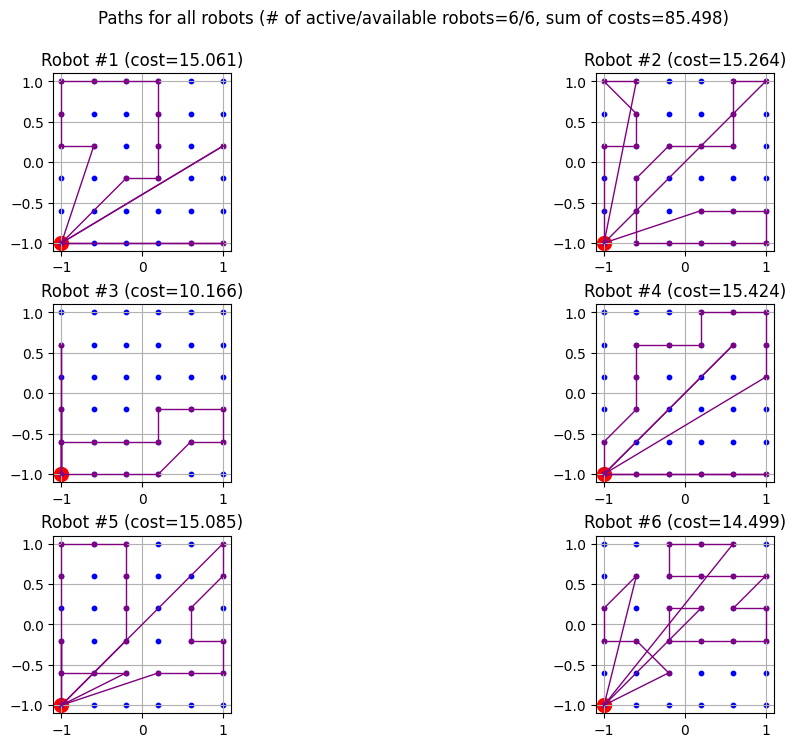

H    0     0                      15.4235496    7.19675  53.3%     -   16s
     0     0    7.19675    0  682   15.42355    7.19675  53.3%     -   16s
     0     0    7.19675    0  553   15.42355    7.19675  53.3%     -   20s
Found a new solution with lower cost(15.030)!


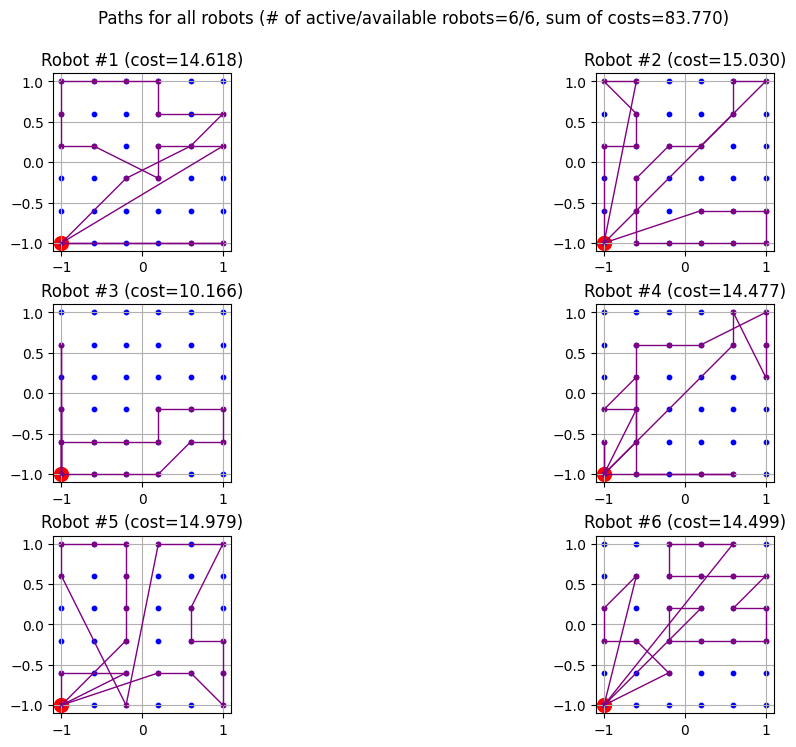

H    0     0                      15.0300023    7.19675  52.1%     -   21s
     0     0    7.19675    0  607   15.03000    7.19675  52.1%     -   22s
     0     0    7.19675    0  570   15.03000    7.19675  52.1%     -   24s
     0     0    7.19675    0  690   15.03000    7.19675  52.1%     -   25s
     0     0    7.19675    0  522   15.03000    7.19675  52.1%     -   28s
     0     0    7.19675    0  504   15.03000    7.19675  52.1%     -   28s
Found a new solution with lower cost(14.499)!


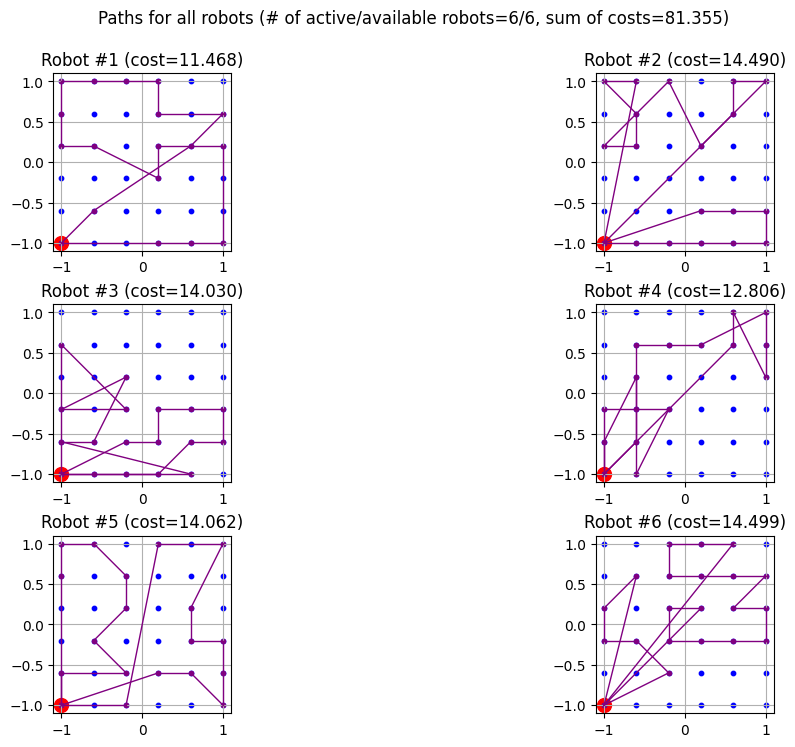

H    0     0                      14.4990317    7.19675  50.4%     -   33s
Found a new solution with lower cost(14.062)!


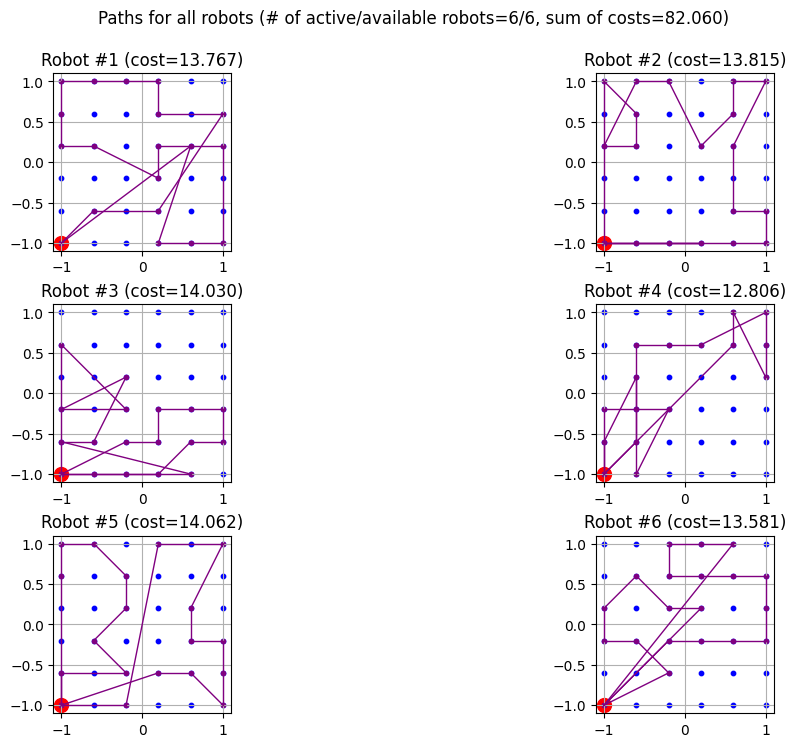

H    0     2                      14.0616878    7.19675  48.8%     -   36s
     0     2    7.19675    0  504   14.06169    7.19675  48.8%     -   36s
    15    30    7.19675    4  660   14.06169    7.19675  48.8%  4615   41s
Found a new solution with lower cost(13.767)!


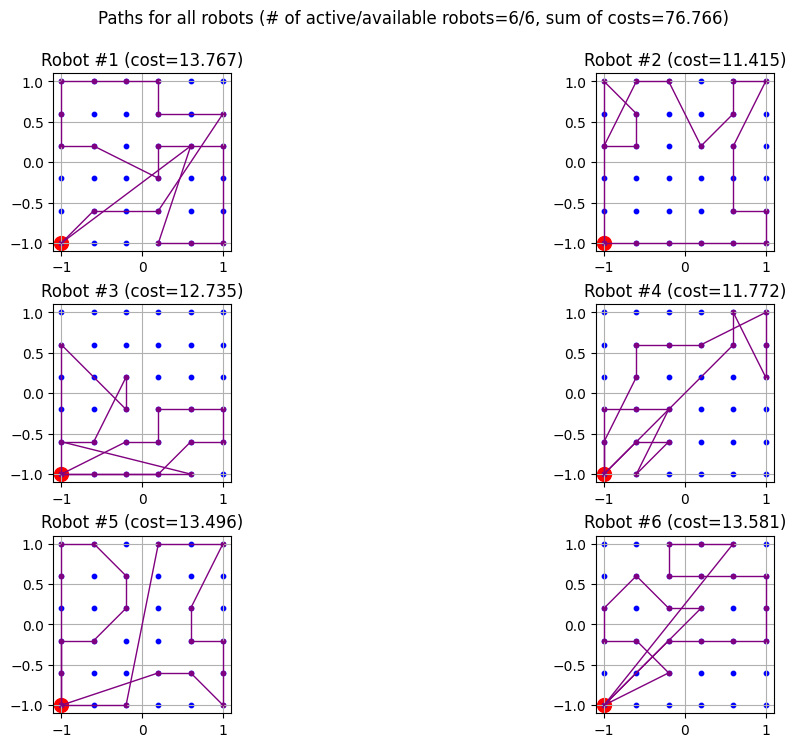

H   29    44                      13.7672442    7.19675  47.7%  4945   59s
Found a new solution with lower cost(12.521)!


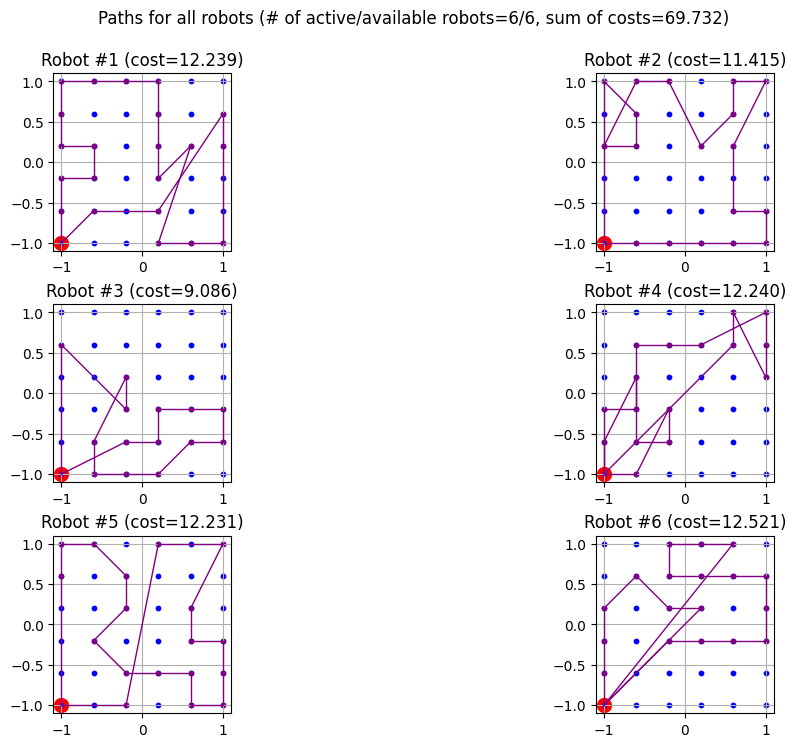

H   31    44                      12.5210477    7.19675  42.5%  5409   60s
Found a new solution with lower cost(11.737)!


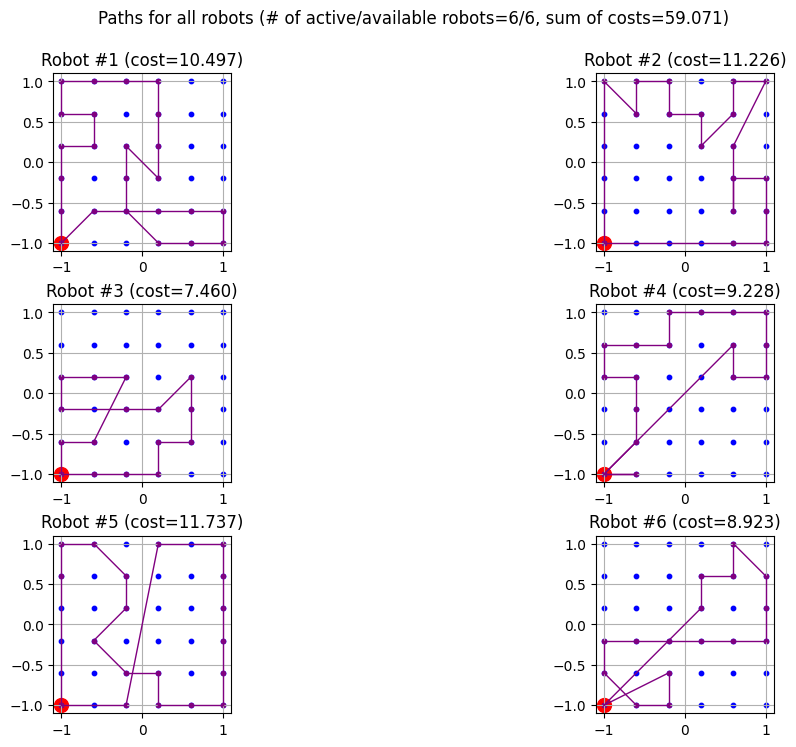

H   38    44                      11.7366641    7.19675  38.7%  8013   61s
    71    86    7.19675    7  625   11.73666    7.19675  38.7%  6632   69s
Found a new solution with lower cost(11.063)!


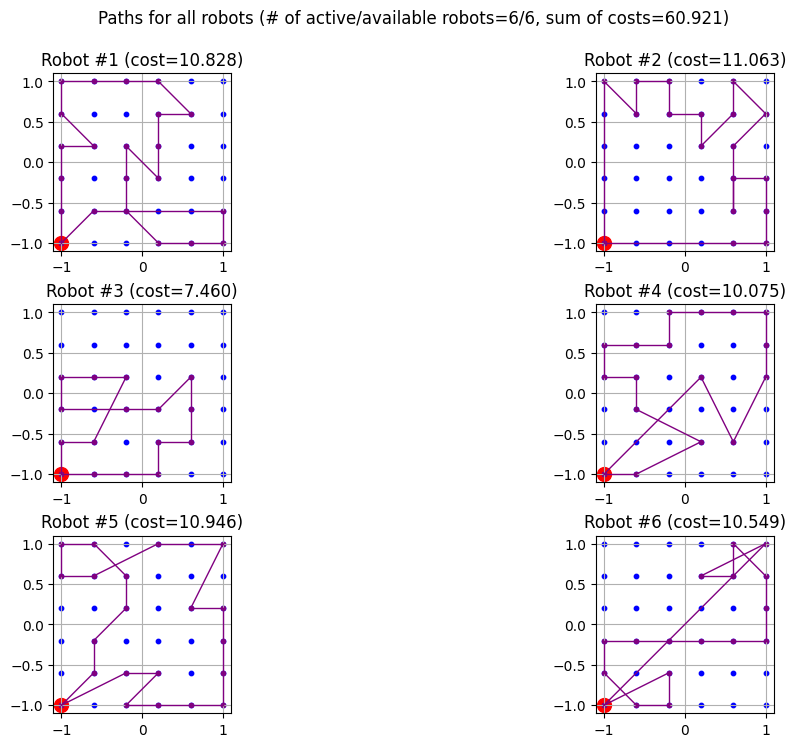

H   73    86                      11.0627417    7.19675  34.9%  6483   70s
Found a new solution with lower cost(10.828)!


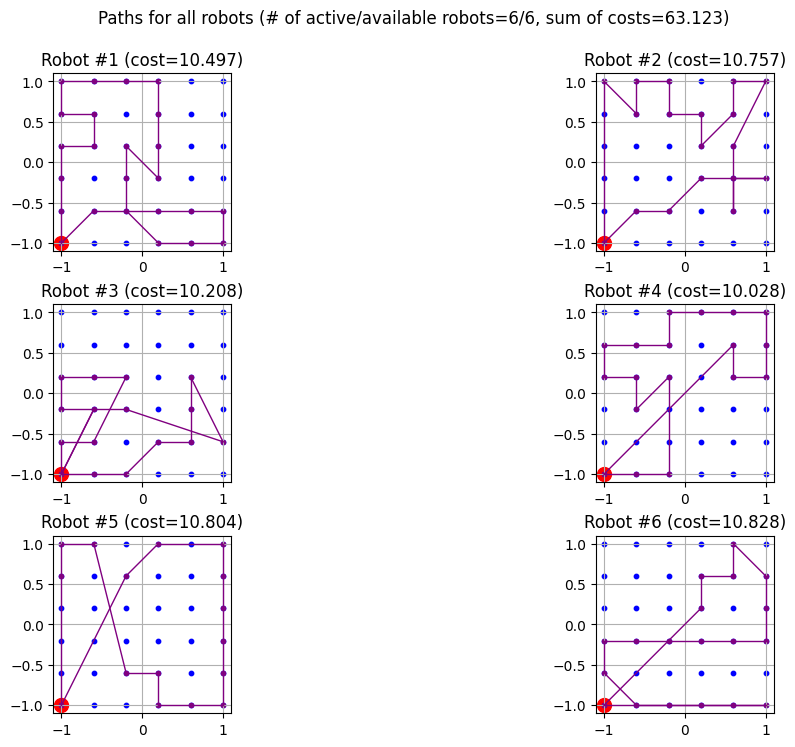

H   84    86                      10.8284271    7.19675  33.5%  5990   71s
   101   116    7.19675    8  632   10.82843    7.19675  33.5%  6470   75s
   168   230    7.19675   13  527   10.82843    7.19675  33.5%  4869   97s
Found a new solution with lower cost(10.782)!


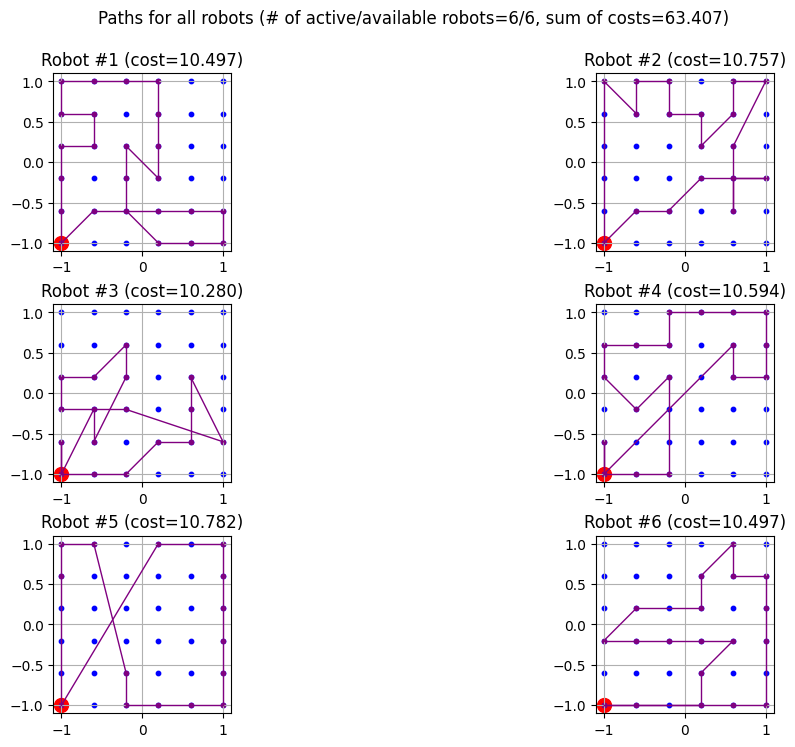

H  188   230                      10.7816230    7.19675  33.2%  4610   98s
Found a new solution with lower cost(10.597)!


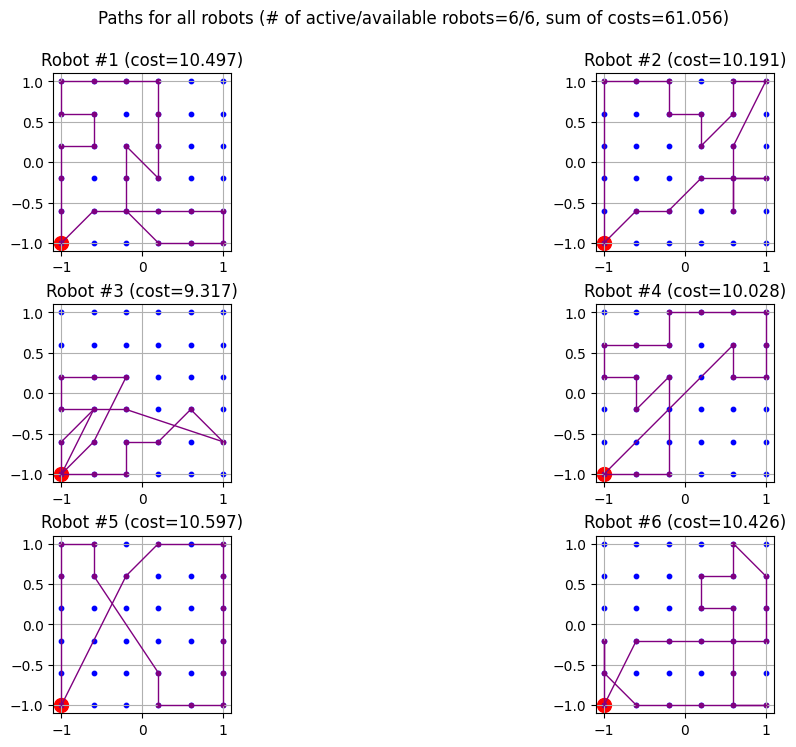

H  214   230                      10.5967603    7.19675  32.1%  4319   99s
Found a new solution with lower cost(10.497)!


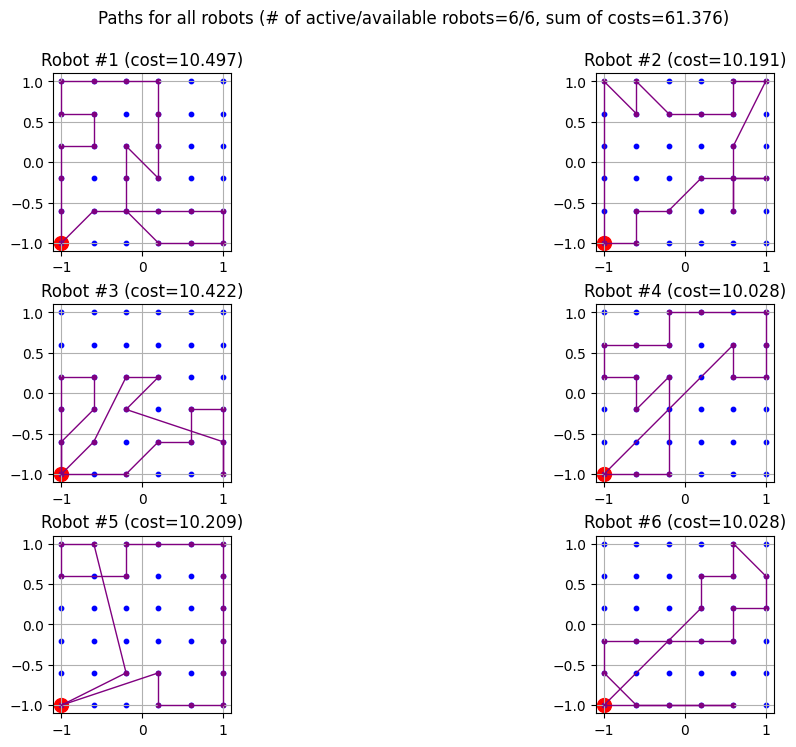

H  215   230                      10.4970563    7.19675  31.4%  4323  100s
   229   416    7.19675   21  594   10.49706    7.19675  31.4%  4194  109s
   415   855    7.24301   35  596   10.49706    7.19675  31.4%  3601  123s
   859  1161    7.29423   63  558   10.49706    7.19675  31.4%  2769  145s
Found a new solution with lower cost(10.426)!


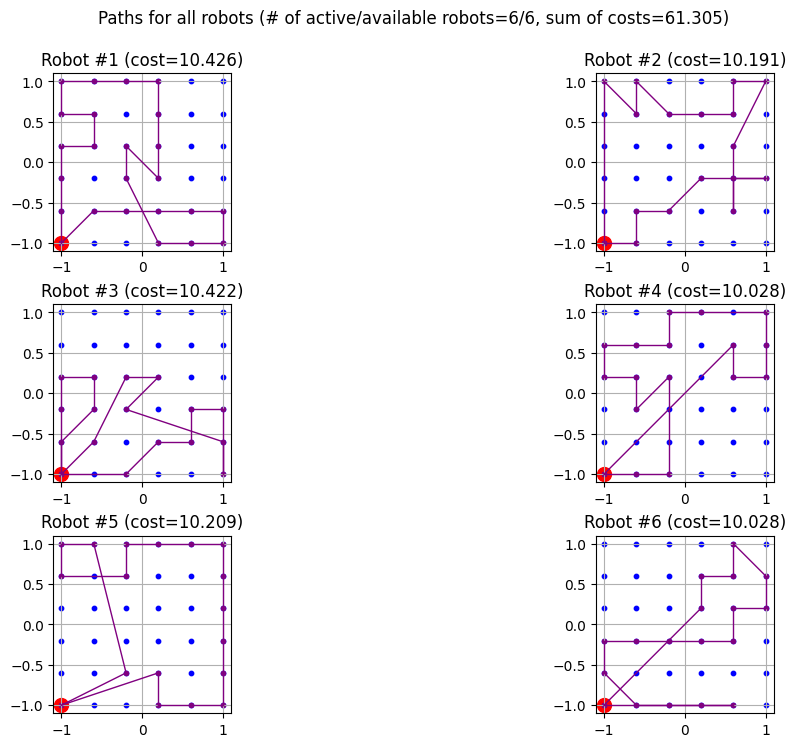

H  882  1161                      10.4257980    7.19675  31.0%  2718  146s
  1178  1481    7.38435   85  548   10.42580    7.19675  31.0%  2487  168s
Found a new solution with lower cost(9.600)!


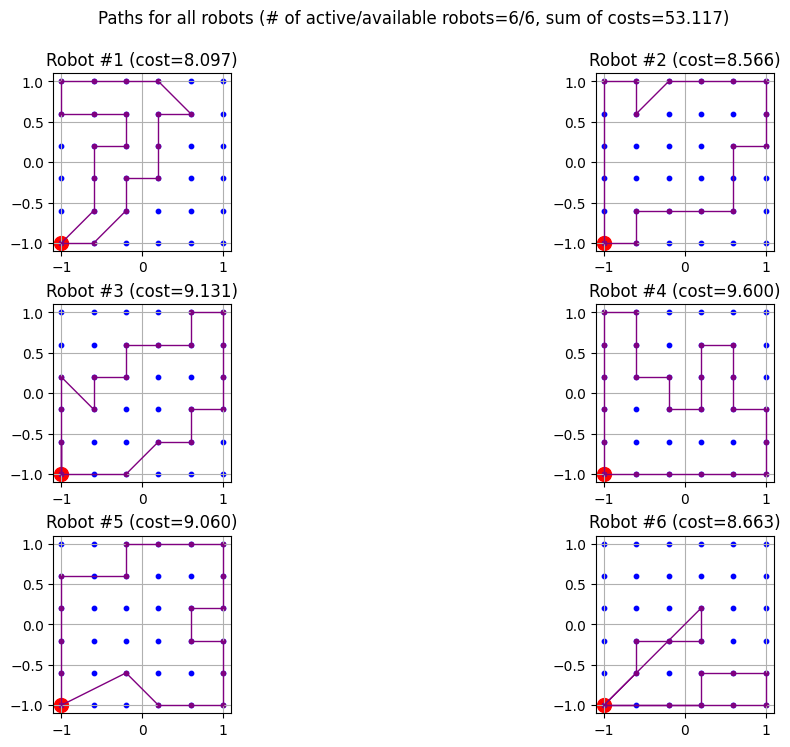

H 1431  1481                       9.6000000    7.19675  25.0%  2293  169s
  1498  2529    7.48714  161  548    9.60000    7.19675  25.0%  2261  185s
  2559  3422    8.07246  275  520    9.60000    7.19675  25.0%  1768  196s
  3471  3837    8.16377  412  506    9.60000    7.19675  25.0%  1556  217s
Found a new solution with lower cost(9.391)!


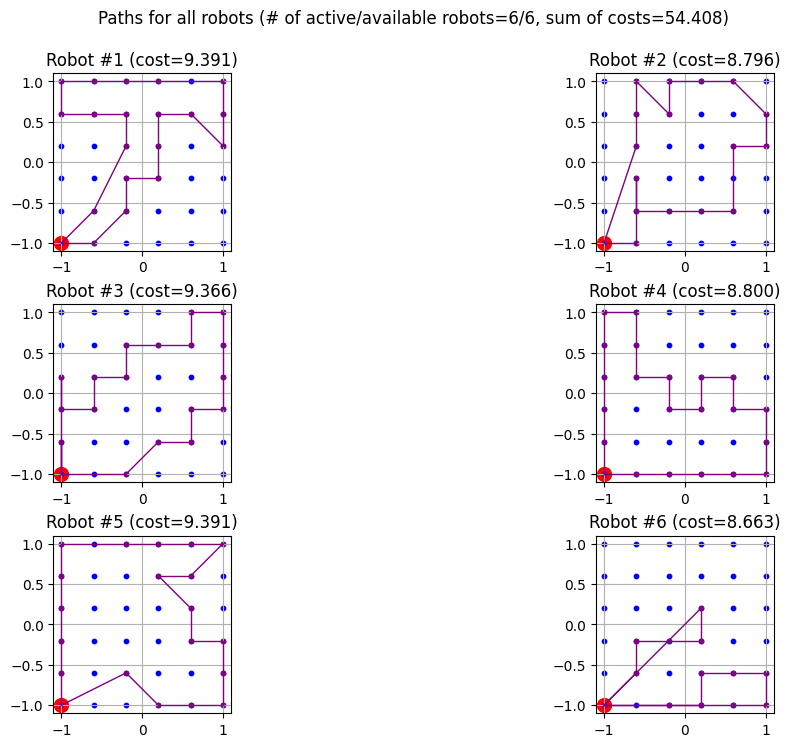

H 3621  3834                       9.3914835    7.19675  23.4%  1499  218s
Found a new solution with lower cost(9.060)!


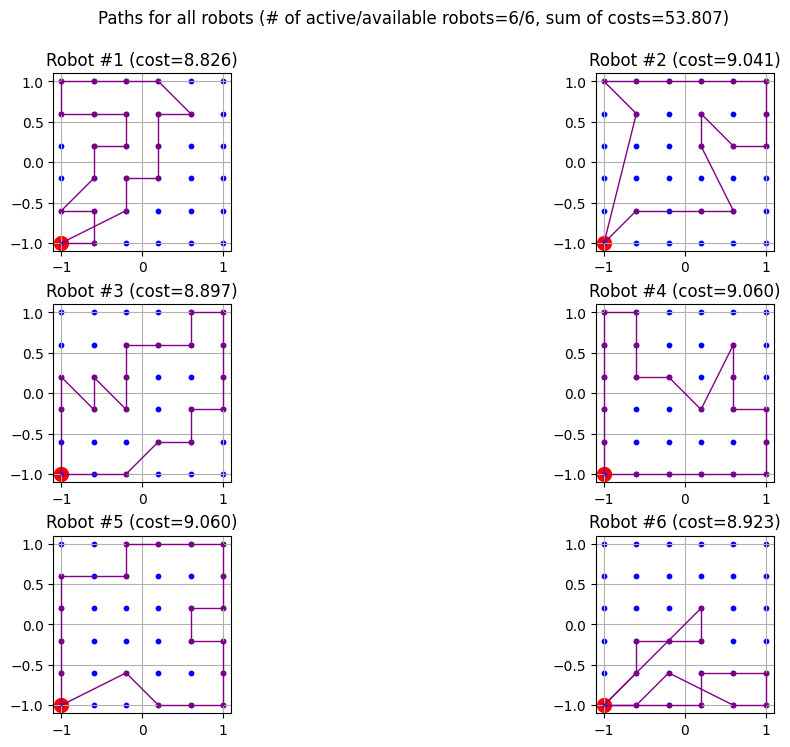

H 3655  3795                       9.0601126    7.19675  20.6%  1502  219s
  3908  4739    8.51628  558  431    9.06011    7.19675  20.6%  1449  229s
  5030  5846    7.24163    6  617    9.06011    7.19675  20.6%  1290  239s
  6225  5951    7.30578   21  567    9.06011    7.19675  20.6%  1165  261s
  6334  7385    7.30856   22  610    9.06011    7.19675  20.6%  1157  270s
  7815  8773    7.47847   53  535    9.06011    7.19675  20.6%  1020  278s
  9279 10010    7.65742  110  562    9.06011    7.19675  20.6%   920  287s
 10534 10011    8.79664  429  504    9.06011    7.19675  20.6%   864  296s
 10536 10012    7.35740   85  476    9.06011    7.19675  20.6%   863  300s
 10537 10013    9.00407  609  659    9.06011    7.19675  20.6%   863  310s
 10539 10014    7.45356   80  520    9.06011    7.29307  19.5%   863  316s
 10541 10016    7.34139   45  601    9.06011    7.34139  19.0%   863  323s
 10543 10017    7.82771  111  713    9.06011    7.34140  19.0%   863  327s
 10545 10018    8.96537 1

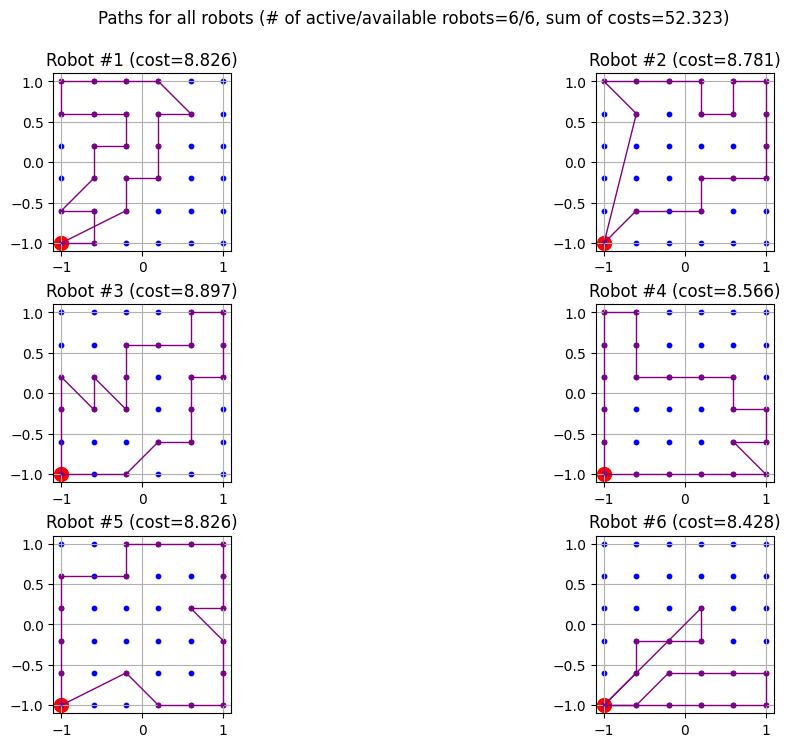

H10552  9521                       8.8970563    7.42245  16.6%   862  357s
 10554  9522    7.44472   64  788    8.89706    7.42258  16.6%   862  360s
 10557  9524    8.09992  203  896    8.89706    7.42449  16.6%   862  367s
 10559  9526    8.47871  314  719    8.89706    7.42553  16.5%   862  372s
Found a new solution with lower cost(8.826)!


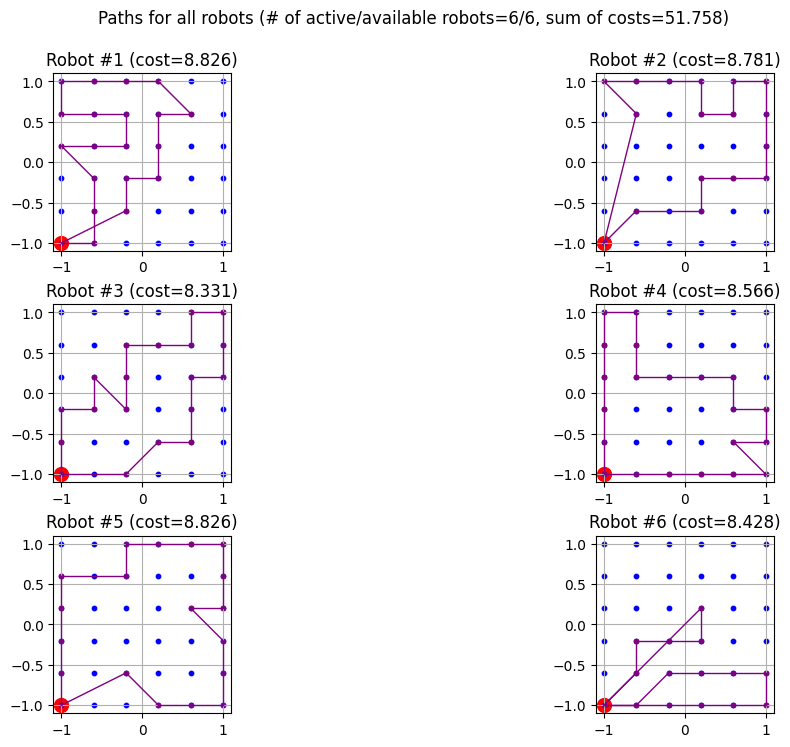

H10560  9049                       8.8257980    7.42553  15.9%   861  376s
 10561  9050    8.54818  390  846    8.82580    7.42555  15.9%   861  380s
 10564  9052    7.51585   46  850    8.82580    7.42624  15.9%   861  385s
 10566  9053    7.97716  186  779    8.82580    7.42627  15.9%   861  390s
 10568  9055    8.82580  447  844    8.82580    7.42627  15.9%   861  395s
 10571  9057    7.42627   17  726    8.82580    7.42627  15.9%   861  402s
 10573  9058    8.69416  994  741    8.82580    7.42627  15.9%   860  407s
 10578  9062    8.82580  554  544    8.82580    7.42627  15.9%   924  411s
 10579  9063    8.03600  219  561    8.82580    7.42627  15.9%   924  421s
 10581  9064    8.44889  210  601    8.82580    7.42627  15.9%   924  425s
 10584  9066    7.42627   79  795    8.82580    7.42627  15.9%   924  430s
 10587  9068    8.82580  855  780    8.82580    7.42627  15.9%   923  435s
 10590  9070    7.85926  211  877    8.82580    7.42627  15.9%   923  441s
 10592  9072    8.08067  

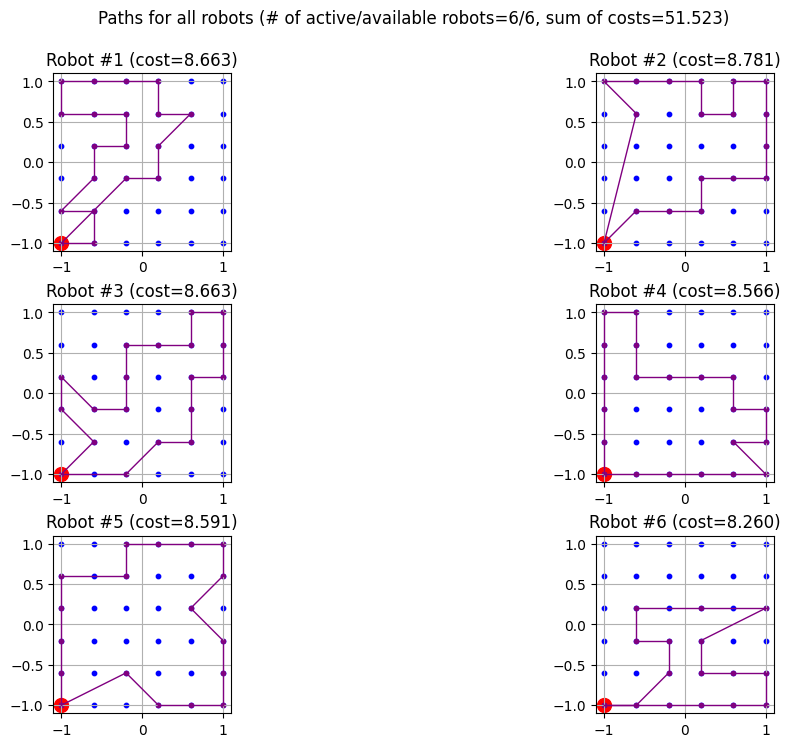

H12804 10100                       8.7806131    7.42781  15.4%   627  668s
 12814 10242    7.59301   79  756    8.78061    7.42781  15.4%   629  671s
Found a new solution with lower cost(8.663)!


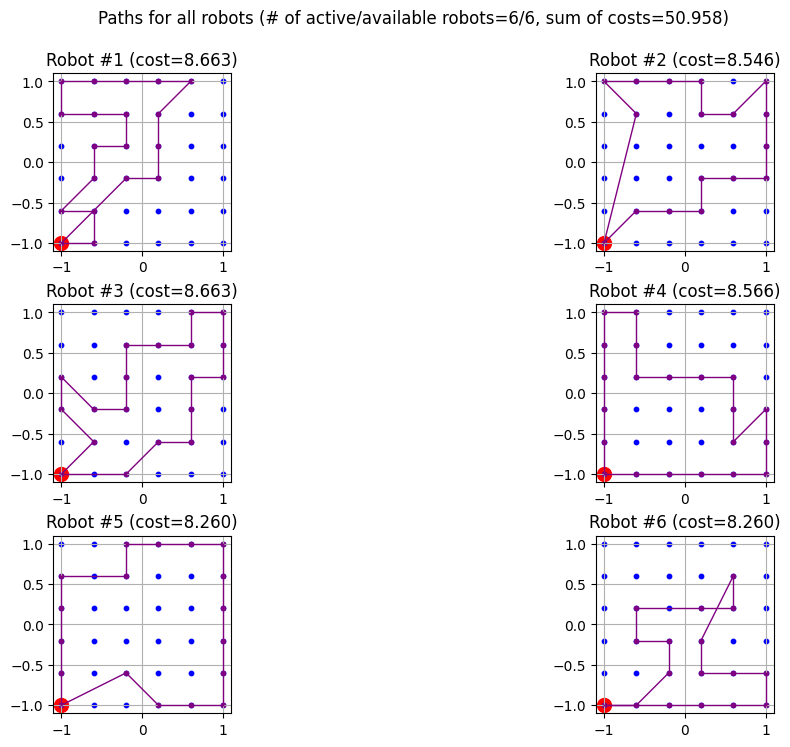

H12982  9884                       8.6627417    7.42781  14.3%   651  675s
Found a new solution with lower cost(8.591)!


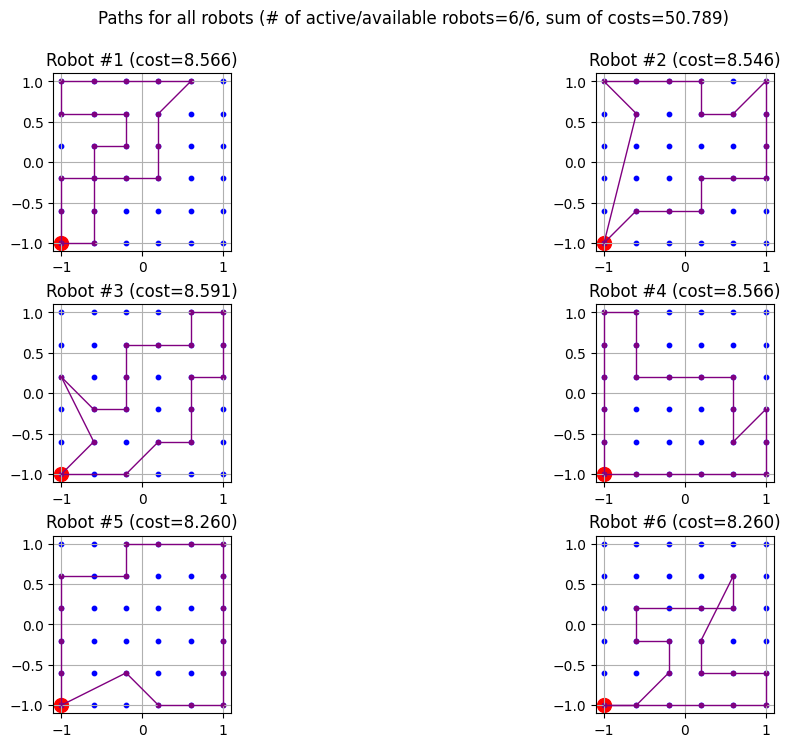

H13211  9566                       8.5914835    7.42781  13.5%   671  680s
 13464  9820    7.59431   92  689    8.59148    7.42781  13.5%   694  688s
 13628  9941    7.59478   94  681    8.59148    7.42781  13.5%   719  692s
 13812 10051    7.65619   98  685    8.59148    7.42781  13.5%   743  696s
Found a new solution with lower cost(8.566)!


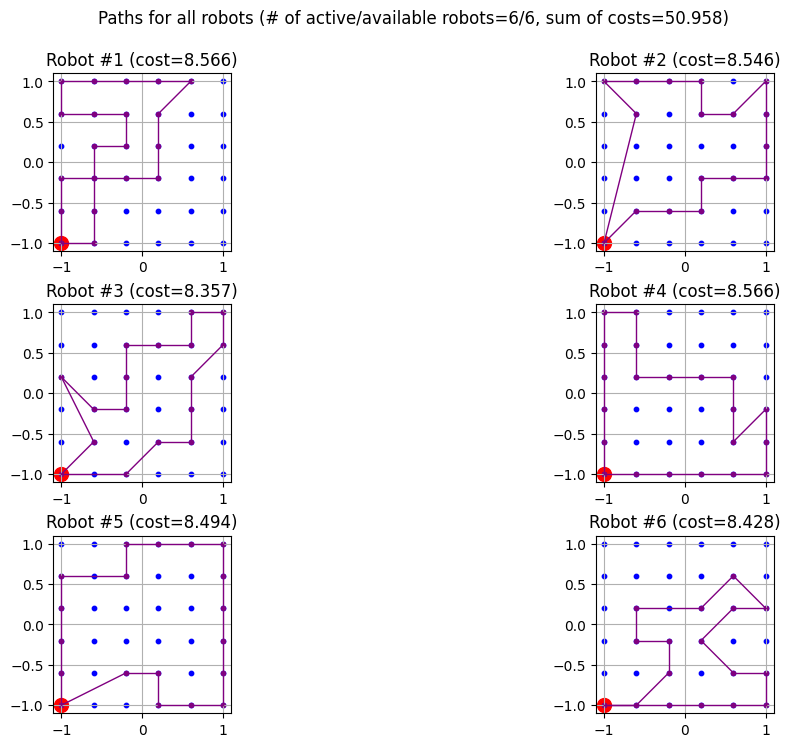

H13828  9654                       8.5656854    7.42781  13.3%   746  697s
 13996  9794    7.63605  103  806    8.56569    7.42781  13.3%   766  703s
 14215  9971    7.73928  106  700    8.56569    7.42781  13.3%   786  708s
 14484 10110    7.64476  108  787    8.56569    7.42781  13.3%   804  715s
 14755 10282    7.64478  111  702    8.56569    7.42781  13.3%   822  723s
 15040 10441    7.64478  114  699    8.56569    7.42781  13.3%   842  729s
 15312 10627    7.64798  118  700    8.56569    7.42781  13.3%   862  734s
 15617 10777    7.82392  121  821    8.56569    7.42781  13.3%   879  751s

Cutting planes:
  Gomory: 8
  Implied bound: 148
  Projected implied bound: 18
  Clique: 30
  MIR: 167
  StrongCG: 6
  Flow cover: 339
  Zero half: 6
  Network: 76
  RLT: 5
  Relax-and-lift: 80

Explored 16042 nodes (23919256 simplex iterations) in 754.17 seconds (2547.44 work units)
Thread count was 14 (of 14 available processors)

Solution count 10: 8.56569 8.59148 8.66274 ... 10.4258

Solve in

In [11]:
m._x = x
solver = MILPSolver(m)
solver.solve()

Robot #0
-------
 -> D36/(-1.00,-1.00)
	neighbor_nodes=[6]
 -> T6/(-0.60,-1.00)
	neighbor_nodes=[7]
 -> T7/(-0.60,-0.60)
	neighbor_nodes=[8]
 -> T8/(-0.60,-0.20)
	neighbor_nodes=[9]
 -> T9/(-0.60,0.20)
	neighbor_nodes=[15]
 -> T15/(-0.20,0.20)
	neighbor_nodes=[16]
 -> T16/(-0.20,0.60)
	neighbor_nodes=[10]
 -> T10/(-0.60,0.60)
	neighbor_nodes=[4]
 -> T4/(-1.00,0.60)
	neighbor_nodes=[5]
 -> T5/(-1.00,1.00)
	neighbor_nodes=[11]
 -> T11/(-0.60,1.00)
	neighbor_nodes=[17]
 -> T17/(-0.20,1.00)
	neighbor_nodes=[23]
 -> T23/(0.20,1.00)
	neighbor_nodes=[29]
 -> T29/(0.60,1.00)
	neighbor_nodes=[22]
 -> T22/(0.20,0.60)
	neighbor_nodes=[21]
 -> T21/(0.20,0.20)
	neighbor_nodes=[20]
 -> T20/(0.20,-0.20)
	neighbor_nodes=[14]
 -> T14/(-0.20,-0.20)
	neighbor_nodes=[2]
 -> T2/(-1.00,-0.20)
	neighbor_nodes=[1]
 -> T1/(-1.00,-0.60)
	neighbor_nodes=[37]
 -> D37/(-1.00,-1.00)
	neighbor_nodes=[0, 36]
 -> T0/(-1.00,-1.00)
	neighbor_nodes=[37]
Robot #1
-------
 -> D36/(-1.00,-1.00)
	neighbor_nodes=[37]
 -> D37/

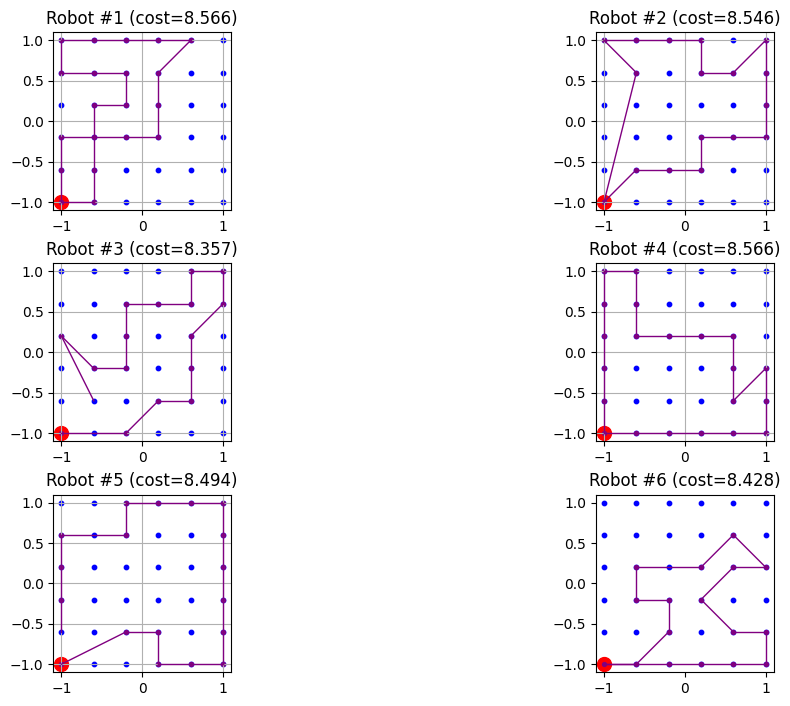

In [32]:
# visualize_paths_brute_force(MILPSolver.min_cost_edges)
visualize_paths_faster(MILPSolver.min_cost_edges)